# Final grade prediction
This work is implemented to predict final grade with a lot of interesting social, gender and study information about students. And in this work, I will try several of model to find the best one. Moreover, I visualize data before feeding forward because I want to know the relationship between variables and eliminate noise ones.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from logger import Logger
import torch.nn.functional as F

In [3]:
with open("data.csv", "r") as f:
    data = pd.read_csv("data.csv")
    variables = data.columns
    print("Name of variables:")
    for i in variables:
        print(i)

Name of variables:
school
sex
age
address
famsize
Pstatus
Medu
Fedu
Mjob
Fjob
reason
guardian
traveltime
studytime
failures
schoolsup
famsup
paid
activities
nursery
higher
internet
romantic
famrel
freetime
goout
Dalc
Walc
health
absences
G1
G2
G3


There are 33 columns in our dataset which there are 17 category variables in, and **G3** is the final grade of students which is also our target.

## Pre-processing data for each columns
Converting categorical variables to continuous variables

In [4]:
school = list(data["school"])
for i in range(len(school)):
    if school[i] == "GP":
        school[i] = 0
    if school[i] == "MS":
        school[i] = 1

sex = list(data["sex"])
for i in range(len(school)):
    if sex[i] == "F":
        sex[i] = 0
    if sex[i] == "M":
        sex[i] = 1

address = list(data["address"])
for i in range(len(school)):
    if address[i] == "U":
        address[i] = 0
    if address[i] == "R":
        address[i] = 1

famsize = list(data["famsize"])
for i in range(len(school)):
    if famsize[i] == "LE3":
        famsize[i] = 0
    if famsize[i] == "GT3":
        famsize[i] = 1

Pstatus = list(data["Pstatus"])
for i in range(len(school)):
    if Pstatus[i] == "T":
        Pstatus[i] = 0
    if Pstatus[i] == "A":
        Pstatus[i] = 1

Mjob = list(data["Mjob"])
for i in range(len(school)):
    if Mjob[i] == "teacher":
        Mjob[i] = 0
    if Mjob[i] == "health":
        Mjob[i] = 1
    if Mjob[i] == "services":
        Mjob[i] = 2
    if Mjob[i] == "at_home":
        Mjob[i] = 3
    if Mjob[i] == "other":
        Mjob[i] = 4

Fjob = list(data["Fjob"])
for i in range(len(school)):
    if Fjob[i] == "teacher":
        Fjob[i] = 0
    if Fjob[i] == "health":
        Fjob[i] = 1
    if Fjob[i] == "services":
        Fjob[i] = 2
    if Fjob[i] == "at_home":
        Fjob[i] = 3
    if Fjob[i] == "other":
        Fjob[i] = 4

reason = list(data["reason"])
for i in range(len(school)):
    if reason[i] == "home":
        reason[i] = 0
    if reason[i] == "reputation":
        reason[i] = 1
    if reason[i] == "course":
        reason[i] = 2
    if reason[i] == "other":
        reason[i] = 3

guardian = list(data["guardian"])
for i in range(len(school)):
    if guardian[i] == "mother":
        guardian[i] = 0
    if guardian[i] == "father":
        guardian[i] = 1
    if guardian[i] == "other":
        guardian[i] = 2

schoolsup = list(data["schoolsup"])
for i in range(len(school)):
    if schoolsup[i] == "yes":
        schoolsup[i] = 0
    if schoolsup[i] == "no":
        schoolsup[i] = 1

famsup = list(data["famsup"])
for i in range(len(school)):
    if famsup[i] == "yes":
        famsup[i] = 0
    if famsup[i] == "no":
        famsup[i] = 1

paid = list(data["paid"])
for i in range(len(school)):
    if paid[i] == "yes":
        paid[i] = 0
    if paid[i] == "no":
        paid[i] = 1

activities = list(data["activities"])
for i in range(len(school)):
    if activities[i] == "yes":
        activities[i] = 0
    if activities[i] == "no":
        activities[i] = 1

nursery = list(data["nursery"])
for i in range(len(school)):
    if nursery[i] == "yes":
        nursery[i] = 0
    if nursery[i] == "no":
        nursery[i] = 1

higher = list(data["higher"])
for i in range(len(school)):
    if higher[i] == "yes":
        higher[i] = 0
    if higher[i] == "no":
        higher[i] = 1

internet = list(data["internet"])
for i in range(len(school)):
    if internet[i] == "yes":
        internet[i] = 0
    if internet[i] == "no":
        internet[i] = 1

romantic = list(data["romantic"])
for i in range(len(school)):
    if romantic[i] == "yes":
        romantic[i] = 0
    if romantic[i] == "no":
        romantic[i] = 1

pre_vars = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup",
            "paid", "activities", "nursery", "higher", "internet", "romantic"]
# Number of classes in each category variables
pre_vars_classes = [2, 2, 2, 2, 2, 5, 5, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2]

# Pre-processing data
pre_data = {}

for i in variables:
    if i not in pre_vars:
        pre_data[i] = list(data[i])
    else:
        exec("pre_data['%s'] = %s" % (i, i))

# Split data
train_data = {}
test_data = {}

for i in variables:
    train_data[i] = list(pre_data[i][:350])
    test_data[i] = list(pre_data[i][350:])

## Selection of input variables
- There are two problem which we need to consider. The first is correlation and the second one is collinearity.

    - Correlation between variables describe the relationship between two variables. If they are extremely correlated, then they are collinear. Autocorrelation occurs when a variable’s data affects another instance of that same variable (same column, different row). Linear regression only works if there is little or no autocorrelation in the dataset, and each instance is independent of each other.
    - Multicollinearity exists when two or more of the predictors (x variables) in a regression model are moderately or highly correlated (different column). When one of our predictors is able to strongly predict another predictor or have weird relationships with each other (maybe x2 = x3 or x2 = 2(x3) + x4), then your regression equation is going to be a mess.

- In this section, I visualize corellation matrix to view relationship between continuous variables

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]), <a list of 16 Text yticklabel objects>)

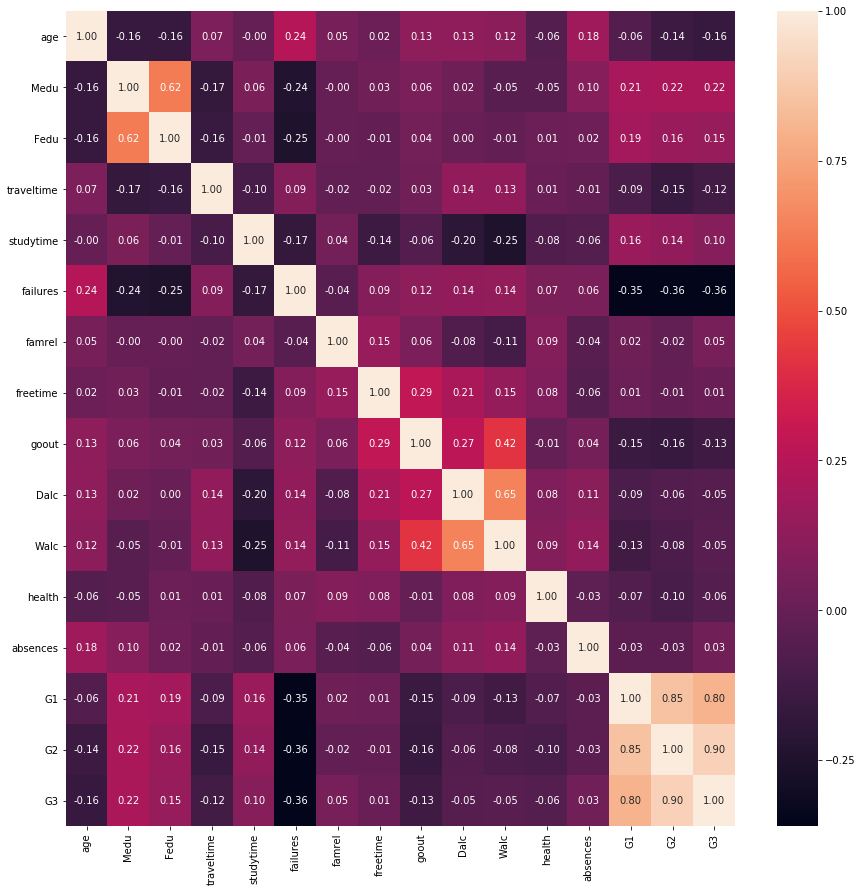

In [5]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cbar=True)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)

- With above correlation maxtrix, you can see there are no dependent variables. Thus, we don't need to eliminate independent variables which are used for regression. And the rest should be used for classification.
- I conduct an experiment using all category variables as a dummy variables, and all numerical variables. The model suffer from overfitting problem (in below figure). I think that category variable $x_i$ have $n_i$ classes, so with $M$ category variables we have $n_1.n_2.n_3...n_M$ cases for classification, and that is a massive number.

<p align="center">
  <img src="imgs/loss.png" width="800" />
  <img src="imgs/acc.png" width="800" /> 
</p>

- We need to find the true insight of data. I realize that there are two true numerical variables (G1, G2) which contribute to linear regression.

<IPython.core.display.Javascript object>


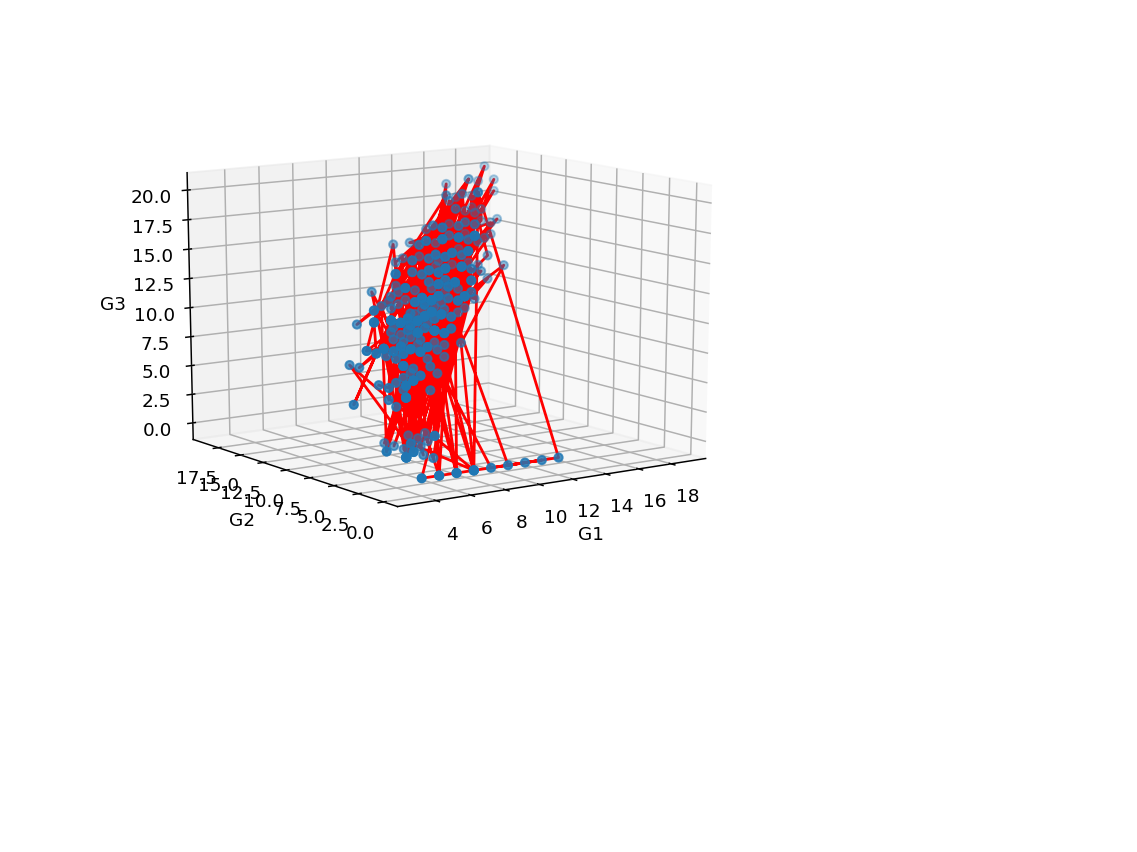

Text(0.5, 0, 'G3')

In [6]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
G1 = pre_data['G1']
G2 = pre_data['G2']
G3 = pre_data['G3']
ax.plot3D(G1, G2, G3, 'red')
ax.scatter3D(G1, G2, G3, cmap='Greens')
ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')

- In this figure, you can relize there is something which split points into two group. The first are points belonging to linear plane and the second one are points which are under this plane.
- With this feature, all of category variables present for two classes.
- I implement a Neural Network model that can regress to point out the effect of each class.

## Model Neural Network

In [13]:
class AlcoholDataset(Dataset):
    def __init__(self, variables, pre_data, pre_vars, pre_vars_classes):
        self.variables = list(variables)
        self.pre_data = pre_data
        self.pre_vars = pre_vars
        self.pre_vars_classes = pre_vars_classes
    
    def __len__(self):
        return len(self.pre_data['G3'])

    def __getitem__(self, idx):
        num_data = []
        cate_data = []
        for i in self.variables[0:30]:
            if i in self.pre_vars:
                cate_data.append(self.pre_data[i][idx])
#             else:
#                 num_data.append(self.pre_data[i][idx])
        num_data.append(self.pre_data['G1'][idx])
        num_data.append(self.pre_data['G2'][idx])
        num_data = torch.tensor(num_data, dtype=torch.float32)

        pre_cate_data = []
        for i in range(len(cate_data)):
            for j in range(self.pre_vars_classes[i]):
                if (j - 1) == cate_data[i]:
                    pre_cate_data.append(1)
                else:
                    pre_cate_data.append(0)

        pre_cate_data = torch.tensor(pre_cate_data, dtype=torch.float32)
        target = torch.tensor(self.pre_data['G3'][idx:idx+1], dtype=torch.float32)
        return num_data, pre_cate_data, target


class Data_loader(object):
    def __init__(self, batch_size, shuffle, variables, pre_data, pre_vars, pre_vars_classes):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset = AlcoholDataset(variables, pre_data, pre_vars, pre_vars_classes)
        
    def loader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=self.shuffle)

In [14]:
train_data_loader = Data_loader(30, True, variables, train_data, pre_vars, pre_vars_classes)
train_data_loader = train_data_loader.loader()

test_data_loader = Data_loader(1, False, variables, test_data, pre_vars, pre_vars_classes)
test_data_loader = test_data_loader.loader()

In [15]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.linear1 = torch.nn.Linear(2, 2)
        self.linear2 = torch.nn.Linear(43, 2)
        self.relu = torch.nn.ReLU(True)
        self.linear3 = torch.nn.Linear(4, 1)
    
    def forward(self, num_data, pre_cate_data):
        x = self.linear1(num_data)
        pre_cate_data = self.linear2(pre_cate_data)
        pre_cate_data  = self.relu(pre_cate_data)
#         x = x * pre_cate_data
        x = torch.cat((x, pre_cate_data), dim=1)
        x = self.linear3(x)
        return x

model = model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.MSELoss()
train_logger = Logger("logs/train")
test_logger = Logger("logs/test")

## Training
- Data is splited into 2 subsets: train (350) and test (45)
- I define the difference between prediction and target is 2

In [16]:
step = 0
num_to_break = 0
total_train_acc = 0
old_test_acc = 0
old_train_acc = 0
while(total_train_acc / 350 < 0.95):
    # Training
    total_train_loss = 0
    total_train_acc = 0
    for batch_idx, (num_data, pre_cate_data, target) in enumerate(train_data_loader):
        step += 1
        train_output = model(num_data, pre_cate_data)
        train_loss = criterion(target, train_output)
        for i in range(train_output.size(0)):
            if abs(train_output[i] - target[i]) <= 2:
                total_train_acc += 1
        total_train_loss += train_loss
        # Clear gradients
        optimizer.zero_grad()
        # Backprop
        train_loss.backward()
        optimizer.step()

    info = {"Loss": total_train_loss / (batch_idx + 1),
             "Accuracy": total_train_acc / 350}
    for tag, value in info.items():
        train_logger.scalar_summary(tag, value, step)
    train_rise = (total_train_acc / 350) - old_train_acc
    old_train_acc = total_train_acc / 350

    # Testing after epoch
    total_test_loss = 0
    total_test_acc = 0
    for batch_idx, (num_data, pre_cate_data, target) in enumerate(test_data_loader):
        test_output = model(num_data, pre_cate_data)
        test_loss = criterion(target, test_output)
        total_test_loss += test_loss
        if abs(test_output[0] - target[0]) <= 2:
            total_test_acc += 1

    info = {"Loss": total_test_loss / (batch_idx + 1),
             "Accuracy": total_test_acc / 45}
    for tag, value in info.items():
        test_logger.scalar_summary(tag, value, step)
    test_rise = (total_test_acc / 45) - old_test_acc
    old_test_acc = total_test_acc / 45
    if train_rise * test_rise < 0:
        num_to_break += 1
    if num_to_break == 5:
        break

- The training achieve accuracy of 89.91, and testing accuracy is 85.99. 
<p align="center">
  <img src="imgs/loss_.png" width="800" />
  <img src="imgs/acc_.png" width="800" /> 
</p>

- And now, I will plot weight of category variables to know there effect to final grade.

[[ 0.1057224  -0.00427923 -0.03275222 -0.06923977  0.07985048  0.06710993
   0.09584837  0.13355903  0.02661943 -0.11353584  0.1297029   0.15205565
   0.15267742  0.34650952  0.02165879 -0.06762532  0.05620094  0.38780648
  -0.14222838 -0.14002421  0.08211456 -0.07144772  0.15574664 -0.21098317
   0.13814706  0.5289076   0.14478207  0.00456001  0.49884665  0.0589586
  -0.07643389  0.1327098   0.11622015  0.08073378 -0.11418173  0.03131273
  -0.2245763   0.00116354  0.21184458  0.08460744  0.15952766  0.12615499
  -0.3097665 ]
 [ 0.14087105  0.13139957  0.13071287 -0.18175107  0.09667297  0.22032927
  -0.04370946  0.30235913  0.0907806  -0.20914993 -0.04281798 -0.01985605
   0.1286138   0.14432171 -0.06552164 -0.11084598  0.08878547  0.35437083
  -0.22283539 -0.04495796  0.04990564  0.19130571  0.25690162  0.00267532
   0.11271268  0.4047096   0.00245439 -0.02674155  0.23772962 -0.01246367
  -0.0318085  -0.10367922  0.17645267 -0.09555472 -0.12393618  0.08844116
  -0.00065255 -0.1226477

<IPython.core.display.Javascript object>


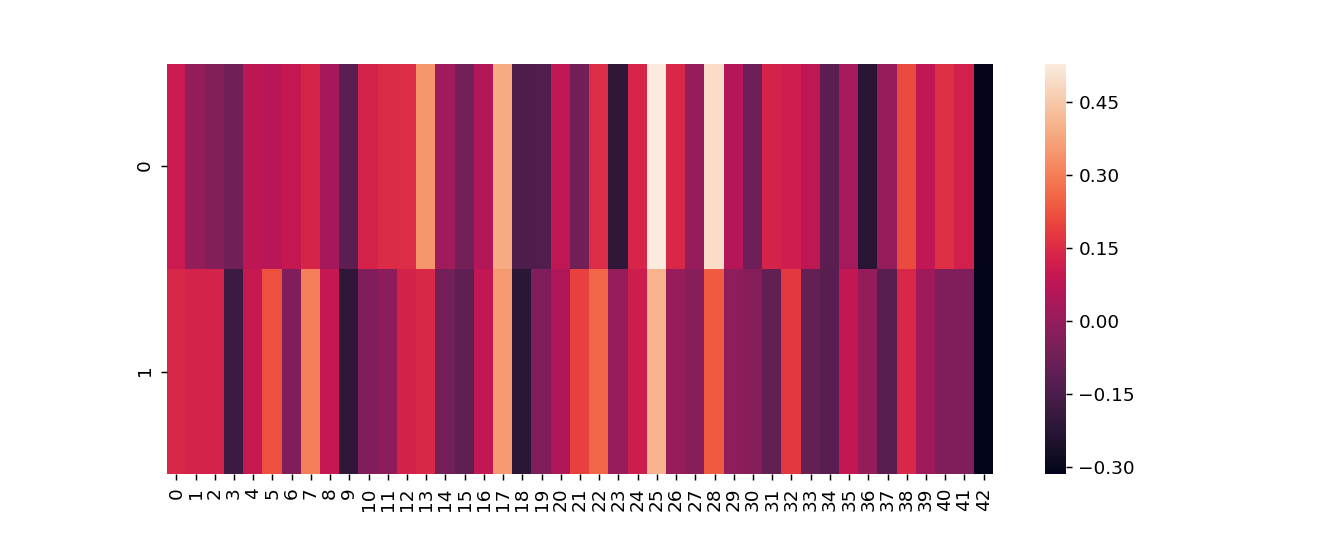

In [36]:
weight = model.linear2.weight.data.numpy()
print(weight)
plt.figure(figsize=(10, 4))
sns.heatmap(weight, fmt=".2f")